In [1]:
import tensorflow as tf

(trainX, trainY), (testX, testY) = tf.keras.datasets.mnist.load_data()
trainX = trainX.reshape(trainX.shape[0], 28, 28, 1).astype('float32')
trainX = (trainX - 127.5) / 127.5
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Create a dataset
train_dataset = tf.data.Dataset.from_tensor_slices(trainX).shuffle(60000).batch(256)

In [2]:
print('Train', trainX.shape, trainY.shape)
print('Test', testX.shape, testY.shape)


Train (60000, 28, 28, 1) (60000,)
Test (10000, 28, 28) (10000,)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2, 2), padding='same', input_shape=[28, 28, 1] ))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [4]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

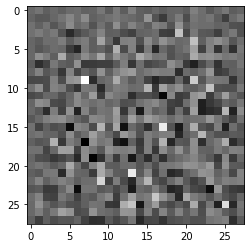

In [5]:
from matplotlib import pyplot
generator = generator()

noise_input = tf.random.normal([1, 100])
generated_image = generator(noise_input, training = False)
pyplot.imshow(generated_image[0, :, :, 0], cmap='gray')



In [6]:
discriminator = discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00169876]], shape=(1, 1), dtype=float32)


In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [11]:
import os
checkpoints_dir = './training_checkpoints'
checkpoints_prefix = os.path.join(checkpoints_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discrimitor_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator
                                 )

In [12]:
EPOCHES = 50
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 256
BUFFER_SIZE = 60000

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
from matplotlib import pyplot
def generate_and_save_images(model, epoch, test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
  predictions = model(test_input, training=False)

  fig = pyplot.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      pyplot.subplot(4, 4, i+1)
      pyplot.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      pyplot.axis('off')

  pyplot.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  pyplot.show()


In [15]:
import time 
from IPython import display
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # 继续进行时为 GIF 生成图像
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 每 15 个 epoch 保存一次模型
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoints_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 最后一个 epoch 结束后生成图片
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [16]:
train(train_dataset, EPOCHES)


ValueError: in user code:

    <ipython-input-13-d874c1f71976>:10 train_step  *
        real_output = discriminator(images, training=True)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__  **
        self.name)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [28, 28, 1]
